In [1]:
import numpy as np
import tensorflow.keras,os
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import *
from matplotlib import pyplot  as plt
from sklearn.model_selection import KFold
import tensorflow as tf
import gc
tf.config.run_functions_eagerly(True)

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
def get_new_vgg(lr):
    model = Sequential()
    model.add(Conv2D(input_shape=(224,224,3),filters=8,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=8,kernel_size=(3,3),padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", kernel_initializer = 'he_normal'))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=512,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units=32,activation="relu"))
    model.add(Dense(units=6, activation="sigmoid"))
    opt = Adam(lr)
    model.compile(optimizer=opt, loss=tensorflow.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])
    return model

In [4]:
model = get_new_vgg(1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                    

In [5]:
train0 = np.load('../Training Dataset/train_signal.npy')
label0 = np.load('../Training Dataset/label_signal.npy')
print(train0.shape)
print(label0.shape)
N = int(label0[:,0].max())+1

(3000, 224, 224, 3)
(3000, 7)


In [6]:
S = 5
kf = KFold(n_splits=S, shuffle=True, random_state=2)
mean_predictions = np.zeros((S,6))
metrics = np.zeros((S,4,100))

testId = 0
for train_index, test_index in kf.split(np.arange(N)):
#for Valid_id in np.arange(N):
    ##split training valid
    mask = np.in1d(label0[:,0], np.array(test_index)) 
    train = train0[~mask,:,:,:]
    label = label0[~mask,1::]
    valid = train0[mask,:,:,:]
    valid_label = label0[mask,1::]
    valid_no = label0[mask,0]
    ##train
    model = get_new_vgg(1e-5)
    csv_logger = CSVLogger('logs/' + str(testId)+'.log')
    #model_checkpoint = ModelCheckpoint('model.hdf5', monitor='loss',verbose=1, save_best_only=False)
    hist = model.fit(train, label, batch_size=32, epochs=100, verbose=1, validation_data=(valid,valid_label), shuffle=True, callbacks=[csv_logger])
    ##record prediction
    prediction = model.predict(valid)
    mean_prediction = prediction.mean(axis = 0)
    mean_predictions[testId] = mean_prediction
    metrics[testId,0,:] = np.array(hist.history['loss'])
    metrics[testId,1,:] = np.array(hist.history['binary_accuracy'])
    metrics[testId,2,:] = np.array(hist.history['val_loss'])
    metrics[testId,3,:] = np.array(hist.history['val_binary_accuracy'])
    print(metrics[testId,:,-1],end = '; Average valid accuracy: ')
    print(metrics[:testId+1,3,-1].mean())
    _ = gc.collect()
    tf.keras.backend.clear_session()
    testId += 1
print(mean_predictions)

C:\Users\Brea-RD\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
75/75 [==============================] - 41s 60ms/step - loss: 1.1336 - binary_accuracy: 0.8752 - val_loss: 0.1889 - val_binary_accuracy: 0.9349
Epoch 2/100
75/75 [==============================] - 4s 49ms/step - loss: 0.3830 - binary_accuracy: 0.9064 - val_loss: 0.1520 - val_binary_accuracy: 0.9438
Epoch 3/100
75/75 [==============================] - 4s 48ms/step - loss: 0.2482 - binary_accuracy: 0.9208 - val_loss: 0.1347 - val_binary_accuracy: 0.9540
Epoch 4/100
75/75 [==============================] - 4s 48ms/step - loss: 0.2042 - binary_accuracy: 0.9304 - val_loss: 0.1282 - val_binary_accuracy: 0.9551
Epoch 5/100
75/75 [==============================] - 3s 45ms/step - loss: 0.1732 - binary_accuracy: 0.9382 - val_loss: 0.1214 - val_binary_accuracy: 0.9576
Epoch 6/100
75/75 [==============================] - 3s 45ms/step - loss: 0.1601 - binary_accuracy: 0.9416 - val_loss: 0.1143 - val_binary_accuracy: 0.9601
Epoch 7/100
75/75 [==============================] - 3s 44ms/st

75/75 [==============================] - 3s 43ms/step - loss: 0.3530 - binary_accuracy: 0.9035 - val_loss: 0.1891 - val_binary_accuracy: 0.9376
Epoch 5/100
75/75 [==============================] - 3s 42ms/step - loss: 0.2980 - binary_accuracy: 0.9099 - val_loss: 0.1876 - val_binary_accuracy: 0.9411
Epoch 6/100
75/75 [==============================] - 3s 45ms/step - loss: 0.2496 - binary_accuracy: 0.9214 - val_loss: 0.1856 - val_binary_accuracy: 0.9409
Epoch 7/100
75/75 [==============================] - 4s 48ms/step - loss: 0.2342 - binary_accuracy: 0.9211 - val_loss: 0.1799 - val_binary_accuracy: 0.9398
Epoch 8/100
75/75 [==============================] - 3s 42ms/step - loss: 0.2236 - binary_accuracy: 0.9268 - val_loss: 0.1781 - val_binary_accuracy: 0.9406
Epoch 9/100
75/75 [==============================] - 3s 46ms/step - loss: 0.2107 - binary_accuracy: 0.9282 - val_loss: 0.1759 - val_binary_accuracy: 0.9409
Epoch 10/100
75/75 [==============================] - 3s 43ms/step - loss: 0

75/75 [==============================] - 3s 45ms/step - loss: 0.2601 - binary_accuracy: 0.9341 - val_loss: 0.2243 - val_binary_accuracy: 0.9465
Epoch 8/100
75/75 [==============================] - 3s 44ms/step - loss: 0.2511 - binary_accuracy: 0.9322 - val_loss: 0.1786 - val_binary_accuracy: 0.9515
Epoch 9/100
75/75 [==============================] - 3s 42ms/step - loss: 0.2110 - binary_accuracy: 0.9393 - val_loss: 0.1668 - val_binary_accuracy: 0.9526
Epoch 10/100
75/75 [==============================] - 3s 43ms/step - loss: 0.1946 - binary_accuracy: 0.9423 - val_loss: 0.1557 - val_binary_accuracy: 0.9518
Epoch 11/100
75/75 [==============================] - 3s 45ms/step - loss: 0.1717 - binary_accuracy: 0.9440 - val_loss: 0.1410 - val_binary_accuracy: 0.9567
Epoch 12/100
75/75 [==============================] - 4s 46ms/step - loss: 0.1648 - binary_accuracy: 0.9473 - val_loss: 0.1431 - val_binary_accuracy: 0.9545
Epoch 13/100
75/75 [==============================] - 3s 42ms/step - loss

76/76 [==============================] - 3s 42ms/step - loss: 0.1977 - binary_accuracy: 0.9323 - val_loss: 0.1508 - val_binary_accuracy: 0.9467
Epoch 11/100
76/76 [==============================] - 3s 43ms/step - loss: 0.1928 - binary_accuracy: 0.9329 - val_loss: 0.1555 - val_binary_accuracy: 0.9456
Epoch 12/100
76/76 [==============================] - 3s 44ms/step - loss: 0.1865 - binary_accuracy: 0.9336 - val_loss: 0.1460 - val_binary_accuracy: 0.9430
Epoch 13/100
76/76 [==============================] - 3s 44ms/step - loss: 0.1652 - binary_accuracy: 0.9401 - val_loss: 0.1478 - val_binary_accuracy: 0.9464
Epoch 14/100
76/76 [==============================] - 3s 44ms/step - loss: 0.1703 - binary_accuracy: 0.9370 - val_loss: 0.1460 - val_binary_accuracy: 0.9473
Epoch 15/100
76/76 [==============================] - 3s 42ms/step - loss: 0.1563 - binary_accuracy: 0.9415 - val_loss: 0.1479 - val_binary_accuracy: 0.9489
Epoch 16/100
76/76 [==============================] - 3s 42ms/step - lo

76/76 [==============================] - 3s 44ms/step - loss: 0.1794 - binary_accuracy: 0.9314 - val_loss: 0.1527 - val_binary_accuracy: 0.9432
Epoch 14/100
76/76 [==============================] - 3s 42ms/step - loss: 0.1729 - binary_accuracy: 0.9359 - val_loss: 0.1442 - val_binary_accuracy: 0.9435
Epoch 15/100
76/76 [==============================] - 3s 41ms/step - loss: 0.1636 - binary_accuracy: 0.9378 - val_loss: 0.1428 - val_binary_accuracy: 0.9458
Epoch 16/100
76/76 [==============================] - 3s 43ms/step - loss: 0.1613 - binary_accuracy: 0.9379 - val_loss: 0.1397 - val_binary_accuracy: 0.9455
Epoch 17/100
76/76 [==============================] - 3s 44ms/step - loss: 0.1548 - binary_accuracy: 0.9397 - val_loss: 0.1366 - val_binary_accuracy: 0.9463
Epoch 18/100
76/76 [==============================] - 3s 42ms/step - loss: 0.1527 - binary_accuracy: 0.9403 - val_loss: 0.1378 - val_binary_accuracy: 0.9472
Epoch 19/100
76/76 [==============================] - 3s 43ms/step - lo

In [7]:
#mean_predictions = np.load('mean_predictions_new.npy')
#metrics = np.load('metrics_new.npy')

In [8]:
print(mean_predictions.shape)
#print(label_original.shape)
print(metrics.shape)

(5, 6)
(563, 5, 100)


In [7]:
metrics[0:5,3,49].mean()

0.9657177448272705

In [10]:
label_original = np.zeros((N,6))
for Valid_id in range(N):
    ##split training valid
    mask = label0[:,0] == np.array(Valid_id)
    valid_label = label0[mask,:]
    #primary_cause[Valid_id] = valid_label[0,:]
    label_original[Valid_id,:] = valid_label[0,1:]

In [33]:
test_index.shape

(103,)

In [32]:
label_5_fold = np.zeros([5,103,6])
for train_index, test_index in kf.split(np.arange(N)):
#for Valid_id in np.arange(N):
    ##split training valid
    mask = np.in1d(label0[:,0], np.array(test_index)) 
    
label_original.shape

(516, 6)

In [18]:
thresholds = np.arange(0.1,0.9,0.01)
scores = np.zeros((len(thresholds),3))
itr = 0
for threshold in thresholds:
    binary_predictions = mean_predictions>threshold
    cm = tf.math.confusion_matrix(label_original.flatten(),binary_predictions.flatten(), num_classes=2)
    precision = (cm[1,1].numpy()/cm[:,1].numpy().sum())
    recall = (cm[1,1].numpy()/cm[1,:].numpy().sum())
    accuracy = (binary_predictions==label_original).mean()
    scores[itr,0] = accuracy
    scores[itr,1] = precision
    scores[itr,2] = recall
    itr += 1
f,ax = plt.subplots()
ax.plot(thresholds,scores[:,0], label='Accuracy')
ax.plot(thresholds,scores[:,1], label='Precision')
ax.plot(thresholds,scores[:,2], label='Recall')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.legend()

InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} Shapes of all inputs must match: values[0].shape = [3378] != values[1].shape = [30] [Op:Pack] name: stack

In [14]:
print(label_original.shape)
print(binary_predictions.shape)

(516, 6)


NameError: name 'binary_predictions' is not defined

In [15]:
thresholds = np.arange(0.1,0.9,0.01)
scores = np.zeros((len(thresholds),6,3))
itr = 0

for threshold in thresholds:
    binary_predictions = mean_predictions>threshold
    for c in range(6):
        cm = tf.math.confusion_matrix(label_original[:,c],binary_predictions[:,c], num_classes=2)
        precision = (cm[1,1].numpy()/cm[:,1].numpy().sum())
        recall = (cm[1,1].numpy()/cm[1,:].numpy().sum())
        accuracy = (binary_predictions[:,c]==label_original[:,c]).mean()
        scores[itr,c,0] = accuracy
        scores[itr,c,1] = precision
        scores[itr,c,2] = recall
    itr += 1

f,ax = plt.subplots(2,3,figsize = (16,8))
ax[0][0].plot(thresholds,scores[:,0,0], label='Accuracy')
ax[0][0].plot(thresholds,scores[:,0,1], label='Precision')
ax[0][0].plot(thresholds,scores[:,0,2], label='Recall')
ax[0][0].set_title('Good')
ax[0][0].set_xlabel('Threshold')
ax[0][0].set_ylabel('Score')
ax[0][0].set_ylim([0.4,1])
ax[0][0].legend()

ax[0][1].plot(thresholds,scores[:,1,0], label='Accuracy')
ax[0][1].plot(thresholds,scores[:,1,1], label='Precision')
ax[0][1].plot(thresholds,scores[:,1,2], label='Recall')
ax[0][1].set_title('Non-wetting')
ax[0][1].set_xlabel('Threshold')
ax[0][1].set_ylabel('Score')
ax[0][1].set_ylim([0.4,1])
ax[0][1].legend()

ax[0][2].plot(thresholds,scores[:,2,0], label='Accuracy')
ax[0][2].plot(thresholds,scores[:,2,1], label='Precision')
ax[0][2].plot(thresholds,scores[:,2,2], label='Recall')
ax[0][2].set_title('Offset')
ax[0][2].set_xlabel('Threshold')
ax[0][2].set_ylabel('Score')
ax[0][2].set_ylim([0.4,1])
ax[0][2].legend()

ax[1][0].plot(thresholds,scores[:,3,0], label='Accuracy')
ax[1][0].plot(thresholds,scores[:,3,1], label='Precision')
ax[1][0].plot(thresholds,scores[:,3,2], label='Recall')
ax[1][0].set_title('Short')
ax[1][0].set_xlabel('Threshold')
ax[1][0].set_ylabel('Score')
ax[1][0].set_ylim([0.4,1])
ax[1][0].legend()

ax[1][1].plot(thresholds,scores[:,4,0], label='Accuracy')
ax[1][1].plot(thresholds,scores[:,4,1], label='Precision')
ax[1][1].plot(thresholds,scores[:,4,2], label='Recall')
ax[1][1].set_title('Dispersion')
ax[1][1].set_xlabel('Threshold')
ax[1][1].set_ylabel('Score')
ax[1][1].set_ylim([0.4,1])
ax[1][1].legend()

ax[1][2].plot(thresholds,scores[:,5,0], label='Accuracy')
ax[1][2].plot(thresholds,scores[:,5,1], label='Precision')
ax[1][2].plot(thresholds,scores[:,5,2], label='Recall')
ax[1][2].set_title('Overflow')
ax[1][2].set_xlabel('Threshold')
ax[1][2].set_ylabel('Score')
ax[1][2].set_ylim([0.4,1])
ax[1][2].legend()

InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} Shapes of all inputs must match: values[0].shape = [516] != values[1].shape = [5] [Op:Pack] name: stack

In [16]:
print('Good accuracy: ' + '{:.2f}'.format((((mean_predictions[:,0]>0.5) ==label_original[:,0])*100).mean()) )
print('Non-wetting accuracy: ' + '{:.2f}'.format((((mean_predictions[:,1]>0.5) ==label_original[:,1])*100).mean()) )
print('Offset accuracy: ' + '{:.2f}'.format((((mean_predictions[:,2]>0.5) ==label_original[:,2])*100).mean()) )
print('Short accuracy: ' + '{:.2f}'.format((((mean_predictions[:,3]>0.5) ==label_original[:,3])*100).mean()) )
print('Dispersion accuracy: ' + '{:.2f}'.format((((mean_predictions[:,4]>0.5) ==label_original[:,4])*100).mean()) )
print('Overflow accuracy: ' + '{:.2f}'.format((((mean_predictions[:,5]>0.5) ==label_original[:,5])*100).mean()) )

ValueError: operands could not be broadcast together with shapes (5,) (516,) 

Text(0.5, 1.0, 'Validation')

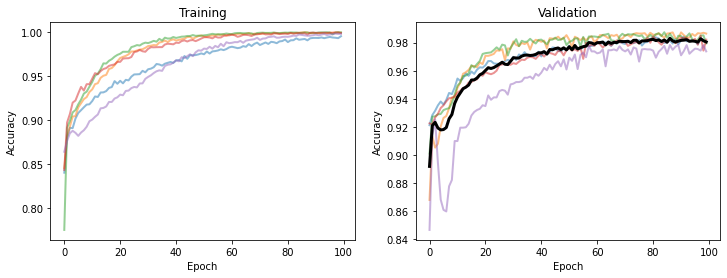

In [23]:
f,ax = plt.subplots(1,2,figsize = (12,4))
for i in range(S):
    ax[0].plot(metrics[i,1,:],alpha = 0.5,linewidth = 2)
    ax[1].plot(metrics[i,3,:],alpha = 0.5,linewidth = 2)
ax[1].plot(metrics[0:5,3,:].mean(axis = 0),alpha = 1,linewidth = 3,color = 'black')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Training')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Validation')

InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} Shapes of all inputs must match: values[0].shape = [516] != values[1].shape = [5] [Op:Pack] name: stack

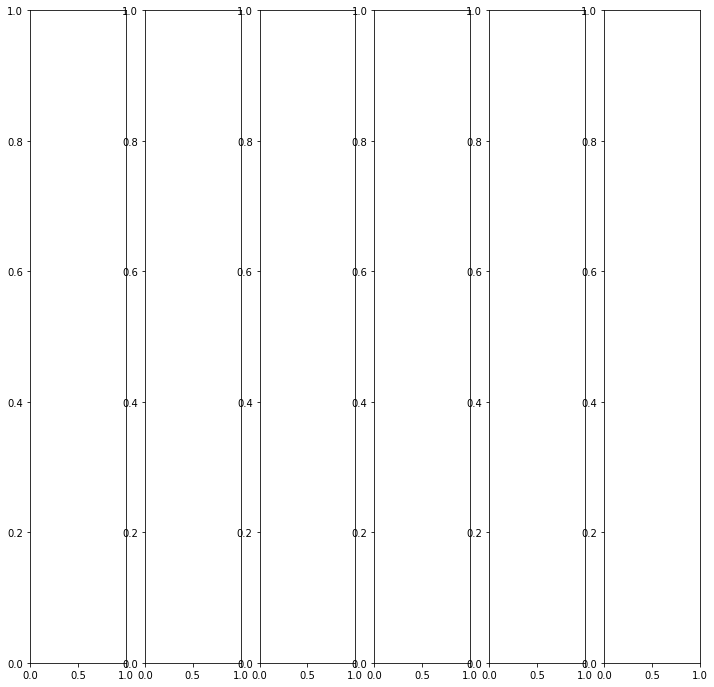

In [24]:
f,ax = plt.subplots(1,6,figsize = (12,12))
for i in range(6):
    cm = tf.math.confusion_matrix(label_original[:,i],mean_predictions[:,i]>0.5, num_classes=2)
    ax[i].imshow(cm,origin='upper')
    ax[i].text( 0-0.2,0,'{:d}'.format(   int(np.round(cm[0,0].numpy()/N*100))   )+'%' , color = 'red')
    ax[i].text( 1-0.2,0,'{:d}'.format(   int(np.round(cm[0,1].numpy()/N*100))   )+'%' , color = 'red')
    ax[i].text( 0-0.2,1,'{:d}'.format(   int(np.round(cm[1,0].numpy()/N*100))   )+'%' , color = 'red')
    ax[i].text( 1-0.2,1,'{:d}'.format(   int(np.round(cm[1,1].numpy()/N*100))   )+'%' , color = 'red')
    ax[i].set_yticks((0,1))
    ax[i].set_xlabel('Pred')
    print('Accuracy: ' + str((cm[1,1].numpy()+cm[0,0].numpy())/cm.numpy().sum()), end = ' ')
    print('Precision: ' + str(cm[1,1].numpy()/cm[:,1].numpy().sum()), end = ' ')
    print('Recall: ' + str(cm[1,1].numpy()/cm[1,:].numpy().sum()))
ax[0].set_ylabel('Label')

In [19]:
np.save('mean_predictions_new.npy', mean_predictions)
np.save('metrics_new.npy', metrics)

In [20]:
##nameList is copied from another script
nameList = []
for i in np.arange(0,40,1):
    nameList_i = ['signal crop/G' + "{:02d}".format(i+1) + '.tif']
    nameList = nameList + nameList_i
for i in np.concatenate((np.arange(0,5,1),np.arange(10,40,1))):
    nameList_i = ['signal crop/N' + "{:02d}".format(i+1) + '.tif']
    nameList = nameList + nameList_i
for i in range(20):
    nameList_i = ['signal crop/F' + "{:02d}".format(i+1) + '.tif']
    nameList = nameList + nameList_i
for i in range(20):
    nameList_i = ['signal crop/S' + "{:02d}".format(i+1) + '.tif']
    nameList = nameList + nameList_i
for i in range(20):
    nameList_i = ['signal crop/D' + "{:02d}".format(i+1) + '.tif']
    nameList = nameList + nameList_i
for i in np.concatenate((np.arange(0,16,1),np.arange(17,20,1),np.arange(22,25,1))):
    nameList_i = ['signal crop/O' + "{:02d}".format(i+1) + '.tif']
    nameList = nameList + nameList_i
#print(nameList)
##label_real is copied from another script
label_real = np.zeros([157,6])
label_real[0:40,0] = 1
label_real[40:40+35,1] = 1
label_real[40+35:40+35+20,2] = 1
label_real[40+35+20:40+35+20+20,3] = 1
label_real[40+35+20+20:40+35+20+20+20,4] = 1
label_real[40+35+20+20+20:40+35+20+20+22+25,5] = 1
label_arg = np.expand_dims(label_real.argmax(axis = 1),axis = 1)
pred_arg = np.expand_dims(mean_predictions.argmax(axis = 1),axis = 1)
    
with open("signal_compare.csv", "wb") as f:
    f.write(b'SampleId,Label,Prediction\n')
    for i in range(len(nameList)):
        l = nameList[i]+','+ str(label_arg[i,0])+","+str(pred_arg[i,0])+'\n'
        f.write(l.encode())